# Project Overview

In this project, I implemented a fully-connected neural network to perform classification on genomic data. The network was designed to distinguish between different populations based on specific patterns in SNP (Single Nucleotide Polymorphism) features. Each input sample was represented by a vector of SNP values, where each SNP was encoded as 0, 1, or 2, depending on the number of reference alleles present.

The classification task was formulated to predict a binary label associated with each individual, based on their genetic data. The network was trained to identify complex patterns and correlations between SNP features and the target variable.

To explore the flexibility and performance of neural networks, I implemented two variants of the architecture:

- A simple feedforward network, without any additional regularization or feature selection.
- An extended version with dropout and L2 regularization, aiming to reduce overfitting and improve generalization.

Throughout the process, I paid special attention to the design of the network architecture, the preprocessing of input data, and the choice of evaluation metrics to ensure robust performance.


## Neural Network Architecture

As part of the model development, I implemented a custom NeuralNetwork class to encapsulate the structure and functionality of a fully connected neural network.

The neural network was designed as a fully connected feedforward model with one hidden layer. The computation followed the structure:

$$
\hat{y} = \sigma(W_1 \cdot \sigma(W_2 \cdot x))
$$

Here:  
- $x$ is the input vector representing the SNP data of an individual.  
- $W_2$ is a weight matrix mapping the input features to the hidden layer of size `middle_layer_dim`.  
- $W_1$ is a weight matrix mapping from the hidden layer to the final output layer.  
- $\sigma$ denotes the sigmoid activation function, which introduces non-linearity at both layers.  
- $\hat{y}$ is the predicted output of the network.

This architecture was chosen to support binary classification based on the input genomic data. The hidden layer allows the model to capture complex interactions between features, while the sigmoid function ensures the outputs are in the range [0, 1], suitable for probability interpretation in binary classification tasks.


## Initialization and Activation Function

As part of the class initialization (`__init__`), I defined and initialized the main components of the network:

- `self.weights1`: a weight matrix connecting the hidden layer to the output.
- `self.weights2`: a weight matrix connecting the input layer to the hidden layer.
- `self.output`: a placeholder vector initialized with zeros to store the final predictions, with one entry per sample.

All weight matrices were initialized with random values to allow learning during the training process.

In addition to the initialization, I implemented the sigmoid activation function, which was used to introduce non-linearity into the network. The function was defined as follows:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

where $z = Wx$ is the linear combination of the input and weights. This activation function ensures that the network outputs values between 0 and 1, which is especially suitable for binary classification problems.


## Feedforward Computation

To perform the feedforward pass, I implemented a function that computes the output of the network based on the current weights and input data. This function uses the initialized weight matrices `self.weights1` and `self.weights2`, along with the input matrix `x`, to propagate the input through the network.

The computation follows these steps:

1. Multiply the input matrix by `weights2`, then apply the sigmoid activation function.
2. Multiply the result by `weights1`, and again apply the sigmoid activation function to obtain the final output vector.

This process can be summarized as:

$$
\hat{y} = \sigma(W_1 \cdot \sigma(W_2 \cdot x))
$$

The final output vector $\hat{y}$ contains values between 0 and 1, representing the predicted probabilities for each input sample. These values are stored in `self.output` and later used for evaluation or further optimization.


## Loss Function and Backpropagation

To evaluate the network's performance, I used the Mean Squared Error (MSE) as the loss function, defined as:

$$
L = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

This function calculates the average squared difference between the predicted values $\hat{y}$ and the true labels $y$. Minimizing this loss allows the network to improve its predictions over time.

To train the network and optimize the weight values, I implemented the backpropagation algorithm based on the gradient descent principle. This process involves computing the gradient of the loss function with respect to the weights and updating the weights in the opposite direction of the gradient to reduce the loss.

The key steps of backpropagation include:

1. **Computing the gradients** of the loss function with respect to the weights ($\frac{\partial L}{\partial W_1}$ and $\frac{\partial L}{\partial W_2}$), using the chain rule and the derivative of the sigmoid activation function:

   $$
   \sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))
   $$

2. **Updating the weights** using the gradients and the learning rate (`self.learning_rate`):

   $$
   W_1 \leftarrow W_1 + \frac{\partial L}{\partial W_1} \cdot LR
   $$

   $$
   W_2 \leftarrow W_2 + \frac{\partial L}{\partial W_2} \cdot LR
   $$

The implementation uses `np.multiply` for element-wise multiplication when computing gradients, which ensures proper dimensional alignment of vectors and matrices throughout the backpropagation process.

This training loop iteratively adjusts the weights to minimize the loss and improve the model’s predictive accuracy.


## Training Function

To train the neural network, I implemented a `train` function that runs the learning process over a predefined number of iterations. The function accepts an input parameter `n_simulations`, which determines how many training cycles the network will perform.

The training function includes the following steps:

1. **Initialization**: A vector named `track_loss` is initialized to store the value of the loss function at each iteration. This helps monitor the learning progress over time.

2. **Training loop**: A `for` loop runs for `n_simulations` iterations. At each iteration:
   - The `feedforward` function is called to compute the current output of the network based on the input and current weights.
   - The `backpropagation` function is then called to calculate the gradients and update the weights using the current prediction (`self.output`) and the true labels.
   - The current loss is calculated and stored in the `track_loss` vector.

This training process allows the network to gradually reduce the loss and improve its predictions as the weights are updated over time.


In [19]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

class NeuralNetwork:
    def __init__(self, x, y, middle_layer_dim, learning_rate):
        self.x = x  # dataset (n x p matrix)
        self.y = y.reshape(-1, 1)  # dataset labels (vector of len n), reshaped to (n, 1)
        self.middle_layer_dim = middle_layer_dim  # dimension of the middle layer
        self.learning_rate = learning_rate  # gradient descent coefficient

        # Initialize weights
        self.weights1 = np.random.rand(self.middle_layer_dim, self.x.shape[1])  # weights between middle layer and input layer
        self.weights2 = np.random.rand(1, self.middle_layer_dim)  # weights between output layer and middle layer

        # Create additional initialized weights
        self.weights1_init = np.copy(self.weights1)  # Initial weights1 to keep for future use
        self.weights2_init = np.copy(self.weights2)  # Initial weights2 to keep for future use

        # Initialize output vector as zeros with the same length as y
        self.output_init = np.zeros(self.y.shape)  # output vector initialized as zeros

    def feedforward(self):
        # Calculate the output of the middle layer
        self.z1 = np.dot(self.x, self.weights1.T)
        self.layer1 = sigmoid(self.z1)  # Using the sigmoid function defined outside the class

        # Calculate the final output
        self.z2 = np.dot(self.layer1, self.weights2.T)
        self.output = sigmoid(self.z2)  # Using the sigmoid function defined outside the class

        # Binarize the output to contain binary values (0 or 1)
        self.output_binary = (self.output > 0.5).astype(int)

        return self.output_binary

    def backpropagation(self):
        # Calculate the error
        error = self.y - self.output

        # Calculate the gradients
        d_z2 = np.multiply(error, sigmoid_derivative(self.z2))
        d_weights2 = np.dot(d_z2.T, self.layer1)

        d_layer1 = np.dot(d_z2, self.weights2)
        d_z1 = np.multiply(d_layer1, sigmoid_derivative(self.z1))
        d_weights1 = np.dot(d_z1.T, self.x)

        # Update the weights
        self.weights1 += self.learning_rate * d_weights1
        self.weights2 += self.learning_rate * d_weights2

    def train(self, n_simulations):
        track_loss = np.zeros(n_simulations)
        for i in range(n_simulations):
            self.feedforward()
            self.backpropagation()
            # Calculate the loss
            loss = np.mean((self.y - self.output) ** 2)
            track_loss[i] = loss
        return track_loss

## Data Loading and Preparation

To begin the analysis, I loaded genomic and demographic data. This process involved the following steps:

1. **loaded the data**

2. **Explored the shape of the data**:  
   - Stored the number of individuals and SNP features using `geno_df.shape`.
   - Printed the dimensions of the genotype DataFrame to understand the dataset structure.

3. **Combined genotype and metadata**:  
   Merged the genotype data (`geno_df`) and individual information (`ind_df`) into a single DataFrame (`combined_df`) by concatenating them column-wise.

4. **Filtered the dataset**:  
   Selected only individuals from specific populations of interest: `'French.HO_PCA'`, `'Turkish.HO_PCA'`, `'Spanish.HO_PCA'`, and `'Unknown'`. The filtered dataset (`filtered_df`) focuses the analysis on these selected groups.


In [20]:
from google.colab import drive
from google.colab import files
from google.colab import auth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
import pandas as pd
def load_df(drive_id, **load_kwargs):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  download = drive.CreateFile({'id': drive_id})
  filename = '{}.csv'.format(drive_id)
  download.GetContentFile(filename)
  return pd.read_csv(filename, **load_kwargs)
drive.mount('/content/drive', force_remount=True)

geno_path = '/content/drive/My Drive/geno_6'
ind_path = '/content/drive/My Drive/ind_6'

geno_df = pd.read_csv(geno_path, header=None, sep=',')
ind_df = pd.read_csv(ind_path, header=None, sep=',', names=['ID', 'Gender', 'Population'])

indep_var = geno_df.shape[1]
observ = geno_df.shape[0]
num_rows, num_columns = geno_df.shape
print(f"\nThe 'geno' data frame has {num_rows} rows and {num_columns} columns.")

# Combine the geno and ind data frames
combined_df = pd.concat([ind_df, geno_df], axis=1)
populations_of_interest = ['French.HO_PCA', 'Turkish.HO_PCA', 'Spanish.HO_PCA', 'Unknown']
filtered_df = combined_df[combined_df['Population'].isin(populations_of_interest)]


Mounted at /content/drive

The 'geno' data frame has 85 rows and 86570 columns.


## Model Training and Loss Visualization

The model was trained using the following parameters:

- `middle_layer_dim = 8` — the number of neurons in the hidden layer.
- `n_simulations = 100` — the number of training iterations.
- `learning_rate = 0.01` — the learning rate for gradient descent.

After training the network with these settings, I visualized the training progress by plotting the loss values stored in the `track_loss` vector. This plot illustrates how the loss decreased over the training iterations, indicating the model’s convergence and learning behavior.


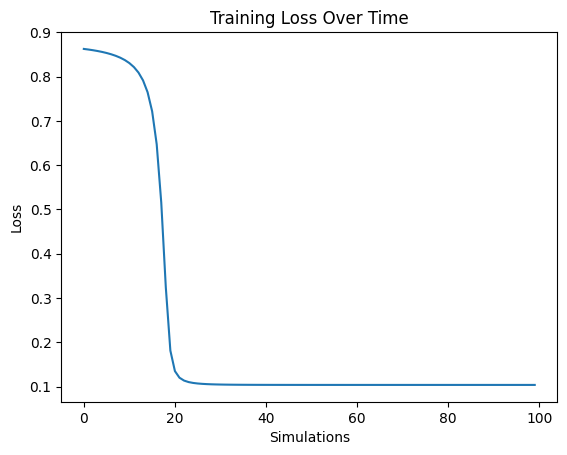

Track Loss: [0.86231833 0.86095861 0.85940869 0.85762695 0.85555898 0.85313242
 0.85024912 0.84677288 0.84250972 0.83717501 0.83033625 0.82130895
 0.80895699 0.79128748 0.76458235 0.72147645 0.64703274 0.51564893
 0.32420213 0.18133046 0.1350032  0.1200868  0.11362618 0.11025504
 0.10828173 0.10703456 0.10620217 0.10562359 0.10520864 0.10490357
 0.10467472 0.10450019 0.10436522 0.10425962 0.10417616 0.10410962
 0.10405618 0.10401297 0.10397784 0.10394912 0.10392554 0.10390609
 0.10389001 0.10387665 0.10386554 0.10385626 0.10384849 0.10384198
 0.10383651 0.1038319  0.10382802 0.10382474 0.10382197 0.10381963
 0.10381764 0.10381595 0.10381452 0.1038133  0.10381227 0.10381138
 0.10381063 0.10380999 0.10380945 0.10380898 0.10380858 0.10380824
 0.10380795 0.10380771 0.10380749 0.10380731 0.10380716 0.10380702
 0.10380691 0.10380681 0.10380673 0.10380666 0.1038066  0.10380654
 0.1038065  0.10380646 0.10380643 0.1038064  0.10380638 0.10380635
 0.10380634 0.10380632 0.10380631 0.1038063  0.103

In [21]:
import numpy as np
import matplotlib.pyplot as plt


X = filtered_df.iloc[:, 4:].values
Y = filtered_df.iloc[:, 3].values

# defining and training
nn = NeuralNetwork(X, Y, middle_layer_dim=8, learning_rate=0.01)
track_loss = nn.train(n_simulations=100)
predictions = nn.feedforward()

# plto of track_loss
plt.plot(track_loss)
plt.xlabel('Simulations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

print("Track Loss:", track_loss)



The graph of the track_loss shows a sharp decrease in loss during the first trainings, and then a stabilization very close to 0.1. This is a good sign indicating that the network is able to learn and reduce the error significantly in the first stage of training.

Based on the graph, it can be said that the training is successful. italicized text

## Train-Test Split and Model Evaluation

To evaluate the model's generalization ability, I extended the neural network implementation by introducing a `train_size` parameter to the `__init__` function. This parameter receives a float value between 0 and 1 and determines the proportion of the data to be used for training.

The input dataset `x` was randomly split into training and testing subsets based on this ratio. For example, if `train_size = 0.8`, then 80% of the data is used for training and the remaining 20% for testing. This ensures that the model is trained only on part of the data, while its performance is evaluated on unseen examples.

The model was trained on the training set using the standard `train` function, and then predictions were generated for the test set using the `feedforward` function.

To assess the predictive performance, I calculated the **Matthews Correlation Coefficient (MCC)** between the true test labels and the predicted values. MCC is a balanced metric that takes into account true and false positives and negatives, and is especially useful for evaluating binary classifiers, even when classes are imbalanced.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

class NN_train:
    def __init__(self, X, Y, train_size, middle_layer_dim, learning_rate, n_simulations):
        # Split the data into training and test sets
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, train_size=train_size, random_state=42)

        # Initialize and train the neural network
        self.nn = NeuralNetwork(self.X_train, self.Y_train, middle_layer_dim, learning_rate)
        self.track_loss = self.nn.train(n_simulations=n_simulations)

        # Test the trained model on the test set
        self.nn.x = self.X_test
        self.nn.y = self.Y_test.reshape(-1, 1)
        self.predictions = self.nn.feedforward()

        # Calculate MCC
        self.mcc = matthews_corrcoef(self.Y_test, self.predictions)

    def plot_loss(self):
        plt.plot(self.track_loss)
        plt.xlabel('Simulations')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.show()

    def print_metrics(self):
        print(f'MCC: {self.mcc:.4f}')



## We will prefer to use MCC over LOSS for 2 main reasons:
1. MCC considers all four cases of classification while LOSS focuses on the average difference between the observation and the forecast.
2. MCC gives a more accurate picture of model performance in cases of imbalance between classes.


Train size: 0.5


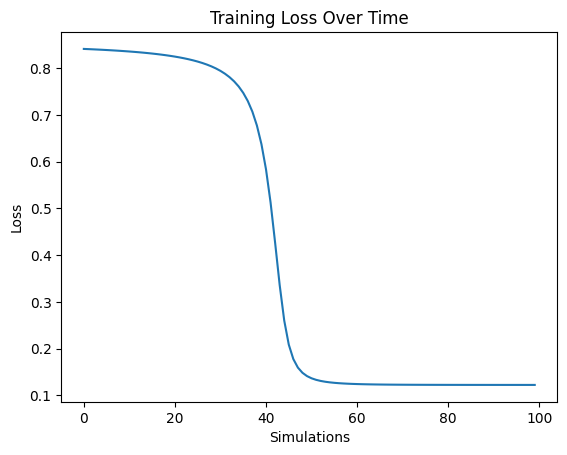

MCC: 0.0000

Train size: 0.75


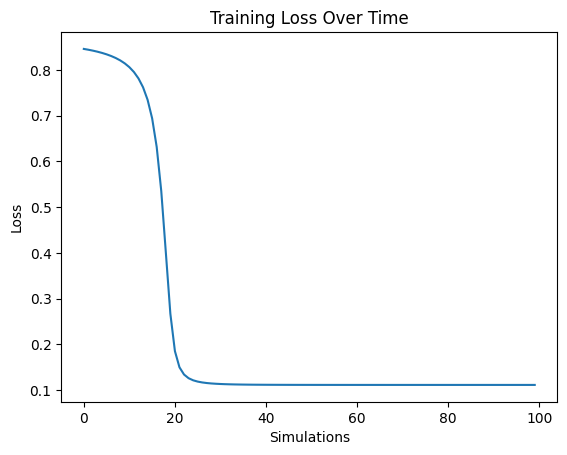

MCC: 0.0000

Train size: 0.9


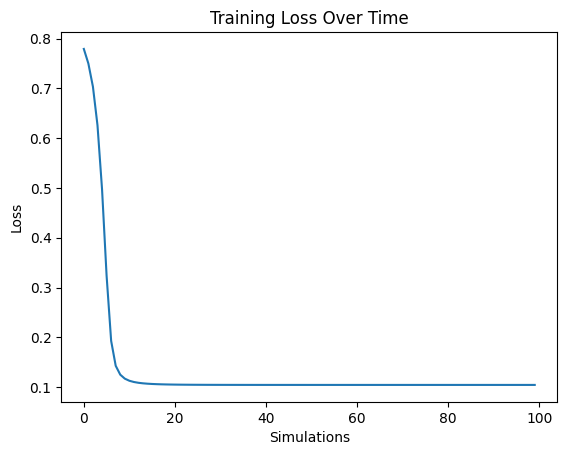

MCC: 0.0000


In [23]:

X = filtered_df.iloc[:, 4:].values
Y = filtered_df.iloc[:, 3].values

train_sizes = [0.5, 0.75, 0.9]

for train_size in train_sizes:
    print(f"\nTrain size: {train_size}")
    nn_train = NN_train(X, Y, train_size=train_size, middle_layer_dim=8, learning_rate=0.01, n_simulations=100)
    nn_train.plot_loss()
    nn_train.print_metrics()


It can be seen that as you increase the training size, the model is more accurate in its prediction results